In [1]:
# sun pos
# https://github.com/s-bear/sun-position?tab=readme-ov-file
!pip install sunposition
!pip install ephem
df = None
import cygno as cy
import pandas as pd
import seaborn as sns
sns.set()
runInfo=cy.read_cygno_logbook(sql=True)
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from skimage.measure import LineModelND, ransac, CircleModel


def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def runsac_ply_fit(x_values, y_values, ax, poly_degree = 1):

    from sklearn.linear_model import (
        LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
    #
    # different regression method can be apply 
    # see https://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html#sphx-glr-auto-examples-linear-model-plot-robust-fit-py
    # see below
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline

#    plt.plot(x_values, y_values, 'r.')
    x_plot = np.linspace(x_values.min(), x_values.max())
    X = np.array(x_values)[:, np.newaxis]

    model = make_pipeline(PolynomialFeatures(poly_degree), RANSACRegressor(min_samples=2,
                                                                           residual_threshold=2,
                                                                           max_trials=1000,
                                                                           random_state=42))
    model.fit(X, y_values)
    mse = mean_squared_error(model.predict(X), y_values)

    y_plot = model.predict(x_plot[:, np.newaxis])
    ax.plot(x_plot, y_plot, 'g-', label='error = %.3f' % (mse))
#    ax.legend()
    return ax

![Image of Yaktocat](https://upload.wikimedia.org/wikipedia/commons/b/b1/Azimuth-Altitude_schematic_it.svg)

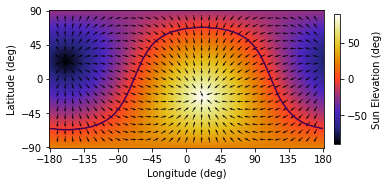

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#sunposition will use numba.jit if available, which may negatively
#impact performance if few positions are being computed.
#To disable jit, before importing sunposition, either set 
#the environment variable NUMBA_DISABLE_JIT to 1 or
#set numba.config.DISABLE_JIT = False
# e.g. import os; os.environ['NUMBA_DISABLE_JIT'] = 1
# or import numba; numba.config.DISABLE_JIT = True
from sunposition import sunpos
from datetime import datetime

#evaluate on a 2 degree grid
lon  = np.linspace(-180,180,181)
lat = np.linspace(-90,90,91)
LON, LAT = np.meshgrid(lon,lat)
#at the current time
now = datetime.utcnow()
az,zen = sunpos(now,LAT,LON,0)[:2] #discard RA, dec, H
#convert zenith to elevation
elev = 90 - zen
#convert azimuth to vectors
u, v = np.cos((90-az)*np.pi/180), np.sin((90-az)*np.pi/180)
#plot
fig, ax = plt.subplots(figsize=(6,3))#,layout='constrained')
img = ax.imshow(elev,cmap=plt.cm.CMRmap,origin='lower',vmin=-90,vmax=90,extent=(-181,181,-91,91))
s = slice(5,-1,5) # equivalent to 5:-1:5
ax.quiver(lon[s],lat[s],u[s,s],v[s,s],pivot='mid',scale_units='xy')
ax.contour(lon,lat,elev,[0])
ax.set_aspect('equal')
ax.set_xticks(np.arange(-180,181,45))
ax.set_yticks(np.arange(-90,91,45))
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
cb = plt.colorbar(img,ax=ax,shrink=0.8,pad=0.03)
cb.set_label('Sun Elevation (deg)')
#display plot
plt.show() #unnecessary in interactive sessions


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sunposition import sunpos
from datetime import datetime, timedelta
# LNGS
# Latitude: 42° 27' 36.00" N
# Longitude: 13° 34' 12.00" E
# https://www.google.com/maps/@42.4531033,13.5739044,2a,75y,321.82h,74.37t/data=!3m6!1e1!3m4!1sqZGY4X4xjCUWhz8hr-eVHQ!2e0!7i13312!8i6656?entry=ttu
now = datetime.utcnow()
print(now)
LAT = 42.4531033
LON = 13.5739044
ele = 1000 # quale e' l'elevazione?

2024-01-05 10:40:31.254482


In [4]:
sunpos(now,LAT,LON,ele) 

(array(172.31059749),
 array(65.43651496),
 array(285.81555779),
 array(-22.64436423),
 array(-7.57920283))

In [5]:
base = datetime(2024, 12, 27)
day = base.strftime('%Y-%m-%d ')
daily_hours = np.array([base + timedelta(hours=i) for i in range(24)])
daily_minutes = np.arange(day+'00:00', day+'23:59', dtype='M8').astype(datetime)
tserie = daily_minutes
# tserie = daily_minutes # per calcolare bene sunset e suna rise usare il minuti
tick = int(len(tserie)/2)

In [6]:
az,zen = sunpos(tserie,LAT,LON,0)[:2]

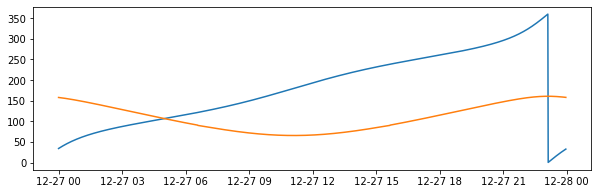

In [7]:
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(tserie, az)
plt.plot(tserie, zen)
plt.show()

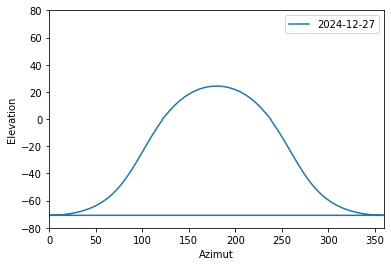

In [8]:
plt.plot(az, 90-zen, label=base.strftime('%Y-%m-%d'))
plt.xlim(0,360)
plt.ylim(-80,80)
plt.xlabel('Azimut')
plt.ylabel('Elevation')
plt.legend()
plt.show()

In [9]:
# per calcolare bene sunset e suna rise usare il minuto almeno
idx = np.abs(90-zen)[:tick].argmin()
print("Sunrise (UTC): "+tserie[idx].strftime('%Y-%m-%d %H:%M'))
idy = np.abs((90-zen)[tick:]).argmin()
print("Sunset (UTC): "+tserie[tick+idy].strftime('%Y-%m-%d %H:%M'))

Sunrise (UTC): 2024-12-27 06:36
Sunset (UTC): 2024-12-27 15:38


In [10]:
import ephem
# test ephem e sunposition a confront
def posizione_astro(latitudine, longitudine, altezza, giorno, ora):
    osservatore = ephem.Observer()
    osservatore.lat = str(latitudine)
    osservatore.long = str(longitudine)
    osservatore.date = giorno + ' ' + ora
    osservatore.elevation = altezza

    astro = ephem.Sun()  # Utilizziamo l'oggetto Sun per il Sole
#    astro = ephem.Moon()
#    astro = ephem.star('Deneb') # stella al centro del cigno
    astro.compute(osservatore)

    altitudine = float(astro.alt) * 180.0 / ephem.pi  # Converti in gradi
    azimuth = float(astro.az) * 180.0 / ephem.pi  # Converti in gradi

    return altitudine, azimuth

now = datetime.utcnow()            # va usata l'ora UTC
latitudine  = 41.975145            # Campaegli
longitudine = 13.103144 
giorno = now.strftime('%Y-%m-%d')  # Data desiderata
ora = now.strftime('%H:%M:%S')     # Ora desiderata (formato HH:MM:SS)
#ora = '15:43:00'
altezza = 1429

alt, az = posizione_astro(latitudine, longitudine, altezza, giorno, ora)
print(f"Posizione approssimativa - Altitudine: {alt} gradi, Azimuth: {az} gradi")
sole = sunpos(now,latitudine,longitudine,altezza)
print(90 - sole[1], sole[0] )

Posizione approssimativa - Altitudine: 24.988586880402856 gradi, Azimuth: 171.82364019504743 gradi
24.990229639362866 171.8258513942626


In [11]:
# genera plk selezione 
def start2epoch(sql_Log, run):
    from datetime import datetime
    date = str(sql_Log[sql_Log.run_number==run].start_time.values[0])
    utc_time = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.000000000")
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    return epoch_time

def where_astro(dechi, latitudine, longitudine, altezza, data):
    import ephem
    osservatore = ephem.Observer()
    osservatore.lat = str(latitudine)
    osservatore.long = str(longitudine)
    osservatore.date = data
    osservatore.elevation = altezza
    if dechi == 'sun':
        astro = ephem.Sun()  # Utilizziamo l'oggetto Sun per il Sole
    elif dechi == 'cygno':
        astro = ephem.star('Deneb')
    elif dechi == 'moon':
        astro = ephem.Moon()
    else:
        print('nessun astro selezionato')
        return 0,0
    astro.compute(osservatore)

    altitudine = float(astro.alt) * 180.0 / ephem.pi  # Converti in gradi
    azimuth = float(astro.az) * 180.0 / ephem.pi  # Converti in gradi

    return altitudine, azimuth

def main(start_run, end_run, file_out_path,verbose=False):
    import numpy as np
    import uproot
    import pandas as pd
    import cygno as cy
    import os
    BASE_URL = 'https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/'
    try:
        runInfo=cy.read_cygno_logbook(sql=True,verbose=verbose)
        if verbose: print(runInfo)
    except Exception as e:
        print('ERROR >>> {}'.format(e))
    
    #runSel = runInfo.loc[runInfo.run_description.str.contains('Stability')]
    runSel = runInfo.loc[runInfo.run_description == 'Standard']

    branches_to_load_e = ['sc_size', 'sc_nhits', 'sc_integral', 'sc_corrintegral', 
                        'sc_rms', 'sc_energy', 'sc_pathlength', 'sc_redpixIdx', 
                        'sc_theta', 'sc_length', 'sc_width', 'sc_longrms', 'sc_latrms', 
                        'sc_lfullrms', 'sc_tfullrms', 'sc_lp0amplitude', 
                        'sc_lp0prominence', 'sc_lp0fwhm', 'sc_lp0mean', 'sc_tp0fwhm', 
                        'sc_xmean', 'sc_ymean', 'sc_xmax', 'sc_xmin', 'sc_ymax', 'sc_ymin', 
                        'sc_pearson', 'sc_tgaussamp', 'sc_tgaussmean', 'sc_tgausssigma', 
                        'sc_tchi2', 'sc_tstatus', 'sc_lgaussamp', 'sc_lgaussmean', 
                        'sc_lgausssigma', 'sc_lchi2', 'sc_lstatus']
    
    branches_to_load_p = ['run', 'event', 'pedestal_run', 'cmos_integral', 'cmos_mean', 
                        'cmos_rms', 't_DBSCAN', 't_variables', 'lp_len', 't_pedsub', 
                        't_saturation', 't_zerosup', 't_xycut', 't_rebin', 
                        't_medianfilter', 't_noisered', 'nSc','Lime_pressure', 
                        'Atm_pressure', 'Lime_temperature', 'Atm_temperature', 
                        'Humidity', 'Mixture_Density']
    
    df = pd.DataFrame(columns = ['run','epoch','tht', 'fft','rate', 'th0_main', 'th0_std','tht_main', 
                                 'tht_std','thl_main', 'thl_std', 'alt_sun', 'az_sun', 'alt_cygno', 
                                 'az_cygno'])
    latitudine = 42.4531033
    longitudine = 13.5739044
    altezza = 1000 # quale e' l'elevazione?
    
    for i, run in enumerate(runSel[(runInfo.run_number>=start_run) & 
                                   (runInfo.run_number<=end_run)].run_number):

        if (runSel[runSel.run_number==run].online_reco_status.values[0]==1 and 
           runSel[runSel.run_number==run].pedestal_run.values[0]==0):
            
            print("analyzing run: ",run, str(runSel[runSel.run_number==run].run_description.values))
            
            #
            # caricamento o creazione del file plk
            #
            file_out_name_e = file_out_path+'reco_run_e_{0:05d}.pkl'.format(run)
            file_out_name_p = file_out_path+'reco_run_p_{0:05d}.pkl'.format(run)
            if os.path.isfile(file_out_name_e) and os.path.isfile(file_out_name_p):
                dfe=pd.read_pickle(file_out_name_e)
                dfp=pd.read_pickle(file_out_name_p)
            else:
                try:
                    file_url = BASE_URL+"cygno-analysis/RECO/Winter23/reco_run{:5d}_3D.root".format(run)
                    tf = uproot.open(file_url)
                    # names = tf["Events;1"].keys()
                    
                    branch_data = {}
                    for branch_name in branches_to_load_e:
                        branch_data[branch_name] = np.hstack(tf["Events;1/"+branch_name].array(library="np"))
                    dfe = pd.DataFrame(branch_data)
                    dfe.to_pickle(file_out_name_e) 
                    branch_data = {}
                    for branch_name in branches_to_load_p:
                        branch_data[branch_name] = np.hstack(tf["Events;1/"+branch_name].array(library="np"))
                    dfp = pd.DataFrame(branch_data)
                    dfp.to_pickle(file_out_name_p) 
                except Exception as e:
                    print('ERROR >>> {}'.format(e))
                    continue
            #
            # analisi
            #
            th0 = 360*np.arctan2((dfe.sc_ymax.values-dfe.sc_ymin.values), 
                 (dfe.sc_xmax.values-dfe.sc_xmin.values))/np.pi
            fake_cut = (dfe.sc_rms>6) & (0.152 * dfe.sc_tgausssigma > 0.5) \
                        & (dfe.sc_integral>1000)
            geo_cut = (dfe.sc_xmin>400) & (dfe.sc_xmax<1900) \
                       & (dfe.sc_ymax<1900) & (dfe.sc_ymin>400)
            # thf = th0[fake_cut]
            # thg = th0[geo_cut]
            # tht = th0[fake_cut and geo_cut]
            tht = 360*np.arctan2((dfe[fake_cut & geo_cut].sc_ymax.values-
                                  dfe[fake_cut & geo_cut].sc_ymin.values), 
                                 (dfe[fake_cut & geo_cut].sc_xmax.values-
                                  dfe[fake_cut & geo_cut].sc_xmin.values))/np.pi
            thl = 360*np.arctan2((dfe[fake_cut & (dfe.sc_length.values>1700)].sc_ymax.values-
                                  dfe[fake_cut & (dfe.sc_length.values>1700)].sc_ymin.values), 
                                 (dfe[fake_cut & (dfe.sc_length.values>1700)].sc_xmax.values-
                                  dfe[fake_cut & (dfe.sc_length.values>1700)].sc_xmin.values))/np.pi
            epoch = start2epoch(runSel, run)
            data_time = datetime.fromtimestamp(epoch).strftime('%Y-%m-%d %H:%M:%S')
#             plt.hist(360*th0/np.pi,18)
#             plt.hist(360*thf/np.pi,18)
#             plt.hist(360*thg/np.pi,18)
#             plt.hist(360*tht/np.pi,18)
            
#             plt.show()
            alt_sun, az_sun = where_astro('sun', latitudine, longitudine, 
                                              altezza, data_time)
            alt_cygno, az_cygno = where_astro('cygno', latitudine, longitudine, 
                                                  altezza, data_time)
            rate = len(tht)
            df.loc[i] = [run, epoch, tht, np.fft.rfft(tht), rate, th0.mean(), th0.std(), tht.mean(),
                         tht.std(), thl.mean(), thl.std(), alt_sun, az_sun, alt_cygno, az_cygno]
    print("DONE")
    return df


In [12]:
#df.to_pickle('/jupyter-workspace/cloud-storage/cygno-analysis/pkl/df.pkl')

### data generator ----------------------------------- (togliere commento if ...)

### end of data generaor ----------------------------

In [13]:
!ls /jupyter-workspace/cloud-storage/cygno-analysis/pkl/df_*.pkl

/jupyter-workspace/cloud-storage/cygno-analysis/pkl/df_30000_1000000.pkl
/jupyter-workspace/cloud-storage/cygno-analysis/pkl/df_40800_1000000.pkl
/jupyter-workspace/cloud-storage/cygno-analysis/pkl/df_7792_1000000.pkl


In [14]:
start_run = 7792
end_run   = 1000000
df=pd.read_pickle('/jupyter-workspace/cloud-storage/cygno-analysis/pkl/df_'+str(start_run)\
             +'_'+str(end_run)+'.pkl')
print(df.columns)

Index(['run', 'epoch', 'tht', 'fft', 'rate', 'th0_main', 'th0_std', 'tht_main',
       'tht_std', 'thl_main', 'thl_std', 'alt_sun', 'az_sun', 'alt_cygno',
       'az_cygno'],
      dtype='object')


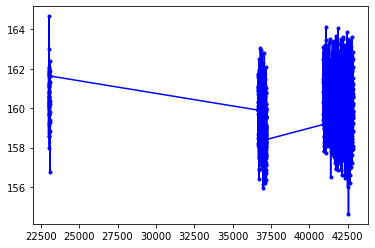

In [15]:
min_cut = 37837
max_cut = 40800
plt.plot(df[(df.run<min_cut) | (df.run>max_cut)].run, df[(df.run<min_cut) | (df.run>max_cut)].thl_main, 'b.-')
plt.show()

In [16]:
df = df[(df.run<min_cut) | (df.run>max_cut)]

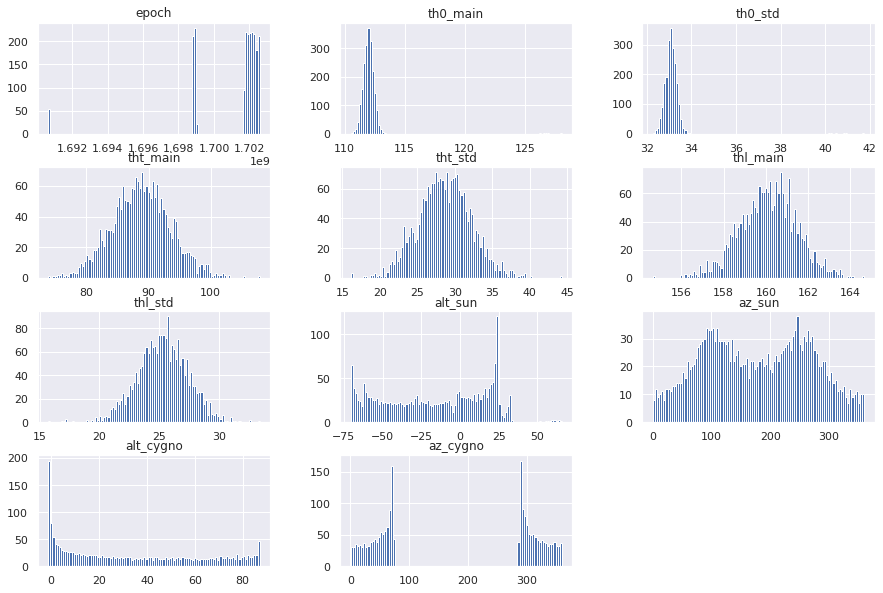

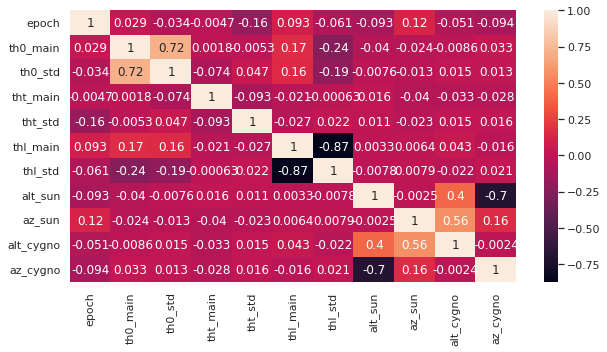

In [17]:
import seaborn as sns
sns.set()

df.hist(bins=100, figsize=(15,10), log=False)
plt.show()

plt.figure(figsize = (10,5))
sns.heatmap(df.corr(), annot=True)
plt.show()

2095
[116.95376123 490.46211563  16.53823254]


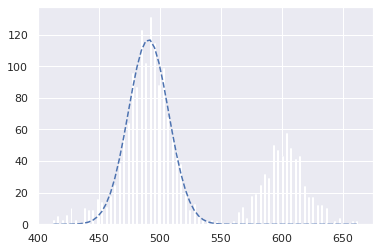

In [18]:

# distanza fra un run e l'altro (in secondi)
bins = 70
upper_limit = 700
y,x = np.histogram(np.gradient(df.epoch)[np.gradient(df.epoch)<upper_limit], bins = bins)
x=x[:-1]
plt.bar(x,y)
popt, pcov = curve_fit(Gauss3,x, y, p0=[140,500, 10])
perr = np.sqrt(np.diag(pcov))
r2=r2_score(y, Gauss3(x, *popt))
print(len(np.gradient(df.epoch)))
plt.plot(x, Gauss3(x, *popt), 'b--')
print(popt)
plt.show()

pick:  2.019018116436299


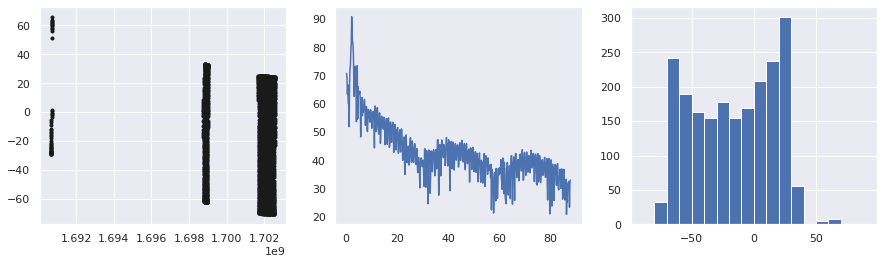

pick:  0.0


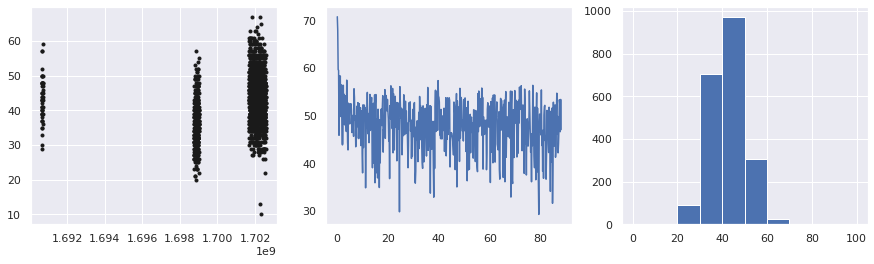

pick:  0.0


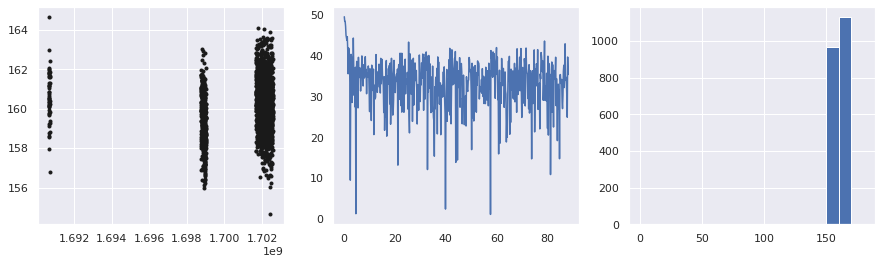

In [19]:
def plt_spectra(y, ax):
    signalFFT = np.fft.rfft(y)
    signalPSD = np.abs(signalFFT) ** 2
    fftFreq = np.fft.fftfreq(len(signalPSD),489.99707781/(24*60*60)) # 494 secondi fra un sample e l'altro 
    i = fftFreq>0
    A = 10*np.log10(signalPSD[i])
    ax.plot(fftFreq[i], A, 'b-')
    ax.grid()
    print("pick: ",fftFreq[np.argmax(A)])
    return ax
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(df.epoch, df.alt_sun, 'k.')
plt_spectra(df.alt_sun, ax[1])
ax[2].hist(df.alt_sun, bins=18, range=(-90, 90))
plt.show()
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(df.epoch, df.rate, 'k.')
plt_spectra(df.rate, ax[1])
ax[2].hist(df.rate, bins=10, range=(0, 100))
plt.show()
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(df.epoch, df.thl_main, 'k.')
plt_spectra(df.thl_main, ax[1])
ax[2].hist(df.thl_main, bins=18, range=(0, 180))
plt.show()
# plt.plot(df.run[(df.run>run_cut) & (df.alt_sun>0)], 
#        df.tht_main[(df.run>run_cut) & (df.alt_sun>0)], 'k.-')
# plt.show()
# plt_spectra(df.tht_main[(df.run>run_cut) & (df.alt_sun>0)])
# plt.plot(df.alt_sun[(df.run>run_cut) & (df.alt_sun>0)], 
#          df.tht_main[(df.run>run_cut) & (df.alt_sun>0)], 'k.')
# plt.show()


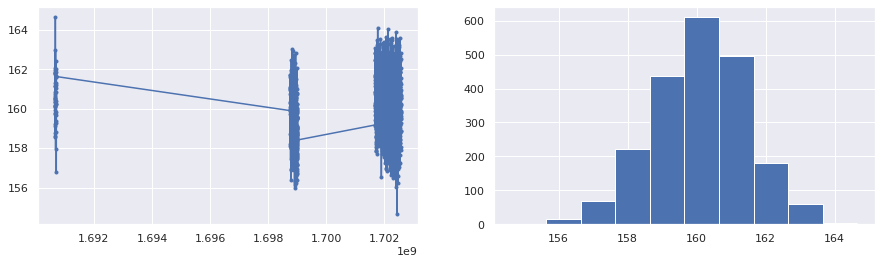

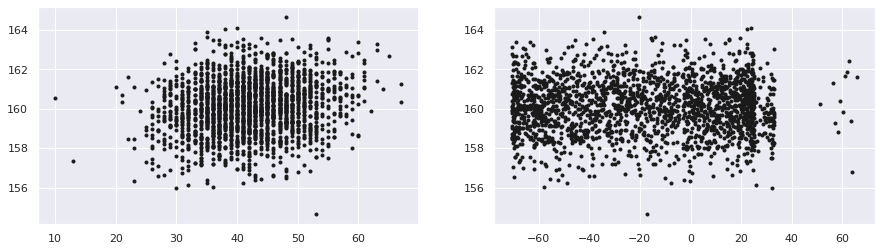

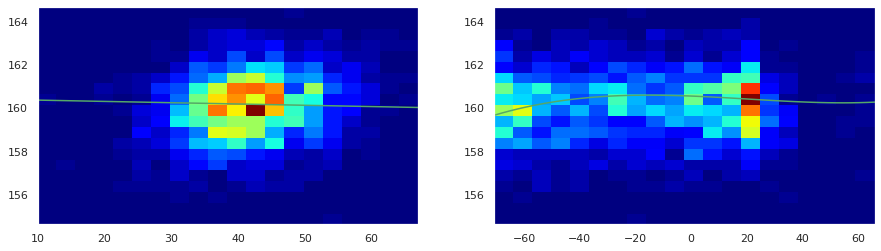

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(df.epoch, df.thl_main, 'b.-')
ax[1].hist(df.thl_main)
plt.show()
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(df.rate, df.thl_main, 'k.')
ax[1].plot(df.alt_sun, df.thl_main, 'k.')
plt.show()
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].hist2d(df.rate, df.thl_main, bins=(20,20), cmap=plt.cm.jet)
runsac_ply_fit(df.rate, df.thl_main, ax[0], poly_degree = 1)
ax[1].hist2d(df.alt_sun, df.thl_main, bins=(20,20), cmap=plt.cm.jet)
runsac_ply_fit(df.alt_sun, df.thl_main, ax[1], poly_degree = 4)
plt.show()

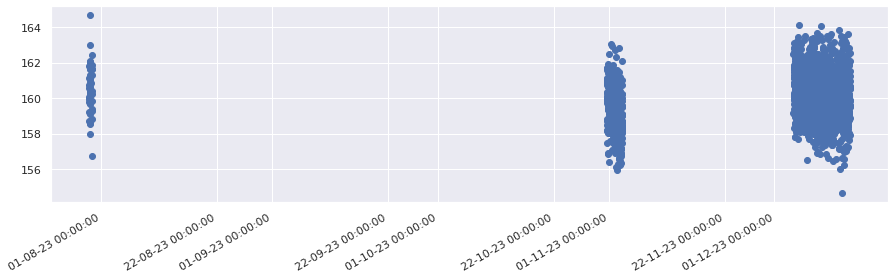

In [21]:
import matplotlib.dates as mdate
secs = mdate.epoch2num(df.epoch)
fig, ax = plt.subplots(figsize=(15,4))

# Plot the date using plot_date rather than plot
ax.plot_date(secs, df.thl_main)

# Choose your xtick format string
date_fmt = '%d-%m-%y %H:%M:%S'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdate.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

# Sets the tick labels diagonal so they fit easier.
fig.autofmt_xdate()

plt.show()

### sigle file debug

In [22]:
import pandas as pd
run=42050
print(">> date: ", runInfo[runInfo.run_number==run].start_time.values[0])
print(">> info: ", runInfo[runInfo.run_number==run].run_description.values[0])
run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run_e_{0:05d}.pkl'.format(run)
dfe=pd.read_pickle(run_name)
run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run_p_{0:05d}.pkl'.format(run)
dfp=pd.read_pickle(run_name)
print(dfe.columns)

>> date:  2023-12-10T07:39:55.000000000
>> info:  Standard
Index(['sc_size', 'sc_nhits', 'sc_integral', 'sc_corrintegral', 'sc_rms',
       'sc_energy', 'sc_pathlength', 'sc_redpixIdx', 'sc_theta', 'sc_length',
       'sc_width', 'sc_longrms', 'sc_latrms', 'sc_lfullrms', 'sc_tfullrms',
       'sc_lp0amplitude', 'sc_lp0prominence', 'sc_lp0fwhm', 'sc_lp0mean',
       'sc_tp0fwhm', 'sc_xmean', 'sc_ymean', 'sc_xmax', 'sc_xmin', 'sc_ymax',
       'sc_ymin', 'sc_pearson', 'sc_tgaussamp', 'sc_tgaussmean',
       'sc_tgausssigma', 'sc_tchi2', 'sc_tstatus', 'sc_lgaussamp',
       'sc_lgaussmean', 'sc_lgausssigma', 'sc_lchi2', 'sc_lstatus'],
      dtype='object')


In [23]:
l2 = np.sqrt((dfe.sc_xmax.values-dfe.sc_xmin.values)**2+
             (dfe.sc_ymax.values-dfe.sc_ymin.values)**2)
m = (dfe.sc_ymax.values-dfe.sc_ymin.values)/(dfe.sc_xmax.values-dfe.sc_xmin.values)
th0 = 360*np.arctan2((dfe.sc_ymax.values-dfe.sc_ymin.values), 
     (dfe.sc_xmax.values-dfe.sc_xmin.values))/np.pi
fake_cut = (dfe.sc_rms>6) & (0.152 * dfe.sc_tgausssigma > 0.5) \
            & (dfe.sc_integral>1000)
geo_cut = (dfe.sc_xmin>400) & (dfe.sc_xmax<1900) \
           & (dfe.sc_ymax<1900) & (dfe.sc_ymin>400)
thf = 360*np.arctan2((dfe[fake_cut].sc_ymax.values-
                      dfe[fake_cut].sc_ymin.values), 
                     (dfe[fake_cut].sc_xmax.values-
                      dfe[fake_cut].sc_xmin.values))/np.pi
thg = 360*np.arctan2((dfe[geo_cut].sc_ymax.values-
                      dfe[geo_cut].sc_ymin.values), 
                     (dfe[geo_cut].sc_xmax.values-
                      dfe[geo_cut].sc_xmin.values))/np.pi
tht = 360*np.arctan2((dfe[fake_cut & geo_cut].sc_ymax.values-
                      dfe[fake_cut & geo_cut].sc_ymin.values), 
                     (dfe[fake_cut & geo_cut].sc_xmax.values-
                      dfe[fake_cut & geo_cut].sc_xmin.values))/np.pi
tht2 = 360*np.arctan2((dfe[fake_cut & (dfe.sc_length.values>1700)].sc_ymax.values-
                      dfe[fake_cut & (dfe.sc_length.values>1700)].sc_ymin.values), 
                     (dfe[fake_cut & (dfe.sc_length.values>1700)].sc_xmax.values-
                      dfe[fake_cut & (dfe.sc_length.values>1700)].sc_xmin.values))/np.pi

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


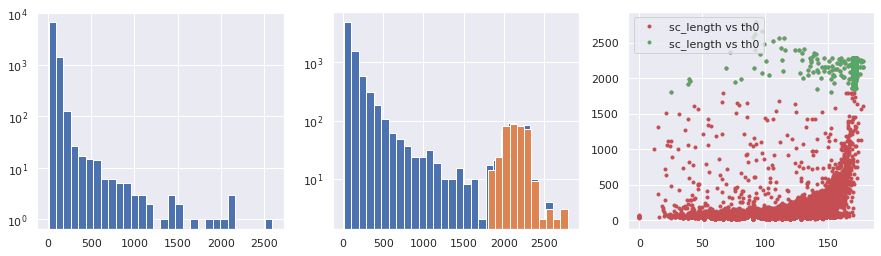

In [24]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].hist(dfe.sc_width.values, 30, log=True, label='sc_width')
ax[1].hist(dfe.sc_length.values, 30, log=True, label='sc_length')
ax[1].hist(dfe[dfe.sc_length.values>1800].sc_length.values, 11, log=True)
ax[2].plot(th0, dfe.sc_length.values, 'r.', label='sc_length vs th0')
ax[2].plot(th0[(dfe.sc_length.values>1800) & (fake_cut)], 
           dfe[(dfe.sc_length.values>1800) & (fake_cut)].sc_length.values, 
           'g.', label='sc_length vs th0')
plt.legend()
plt.show()

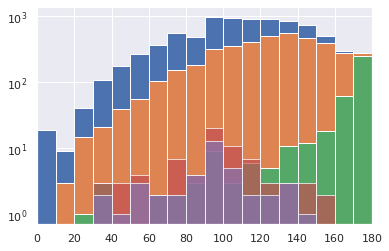

In [25]:
plt.hist(th0,bins=18,range=(0,180))
plt.hist(thf,bins=18,range=(0,180))
plt.hist(tht2,bins=18,range=(0,180))
plt.hist(thg,bins=18,range=(0,180), alpha = 0.7)
plt.hist(tht,bins=18,range=(0,180), alpha = 0.7)
plt.xlim(0,180)

plt.yscale('Log')
plt.show()

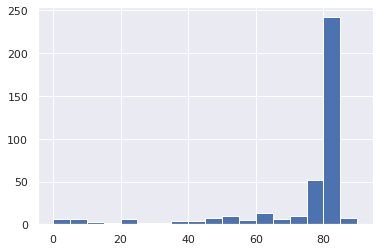

In [26]:
plt.hist(abs(90-tht2),18,range=(0,90))
plt.show()

### general debug and tests

In [27]:
int(10*len(th0))

84360

In [28]:
180/18

10.0

In [75]:
x = np.linspace(0,10*3.14,1000)
n = np.random.normal(0, 0.1, 1000)
#n = np.random.rand(1,1000)[0]
y = np.sin(x+n)
f = np.fft.rfft(y)
sample = len(x)
sample_freq = 1 # esempio 1 sample ogni 1 secondi
r = np.fft.rfftfreq(len(x), 1/sample_freq)

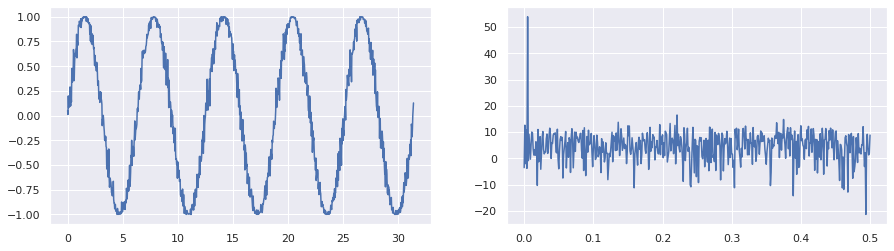

In [76]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(x,y)
ax[1].plot(r,10*np.log10(np.abs(f)**2))
plt.show()

In [72]:
np.random.rand(1000,1)

array([[5.00081322e-01],
       [7.67310852e-01],
       [4.30560998e-02],
       [6.06706632e-01],
       [9.00316747e-01],
       [7.73957328e-01],
       [3.78607546e-02],
       [3.94767807e-02],
       [8.11661971e-01],
       [9.00332916e-01],
       [4.50877747e-01],
       [7.56611343e-01],
       [2.13595546e-01],
       [4.77086901e-01],
       [7.30750705e-01],
       [2.97867343e-01],
       [8.47077845e-01],
       [2.69636726e-01],
       [5.50672855e-01],
       [1.34645224e-01],
       [1.41943311e-01],
       [6.73205517e-01],
       [8.86542617e-01],
       [6.91226960e-01],
       [5.53065485e-01],
       [3.89704976e-01],
       [5.69558547e-01],
       [5.67348461e-01],
       [9.03606084e-02],
       [1.19633602e-01],
       [8.49065582e-01],
       [7.41108626e-01],
       [8.64559145e-01],
       [1.70687969e-01],
       [4.19159111e-01],
       [5.29442194e-01],
       [6.19703438e-01],
       [8.61324008e-01],
       [3.44930528e-01],
       [4.67683331e-01],


In [32]:
def runsac_ply_fit(x_values, y_values, ax, poly_degree = 1):

    from sklearn.linear_model import (
        LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
    #
    # different regression method can be apply 
    # see https://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html#sphx-glr-auto-examples-linear-model-plot-robust-fit-py
    # see below
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline

#    plt.plot(x_values, y_values, 'r.')
    x_plot = np.linspace(x_values.min(), x_values.max())
    X = np.array(x_values)[:, np.newaxis]

    model = make_pipeline(PolynomialFeatures(poly_degree), RANSACRegressor(min_samples=2,
                                                                           residual_threshold=2,
                                                                           max_trials=1000,
                                                                           random_state=42))
    model.fit(X, y_values)
    mse = mean_squared_error(model.predict(X), y_values)

    y_plot = model.predict(x_plot[:, np.newaxis])
    ax.plot(x_plot, y_plot, 'g-', label='error = %.3f' % (mse))
#    ax.legend()
    return ax


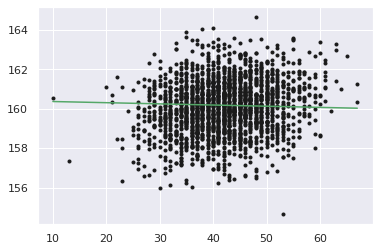

In [33]:
fig,ax = plt.subplots()
ax.plot(df.rate, df.thl_main, 'k.')
runsac_ply_fit(df.rate, df.thl_main, ax, poly_degree = 1)
plt.show()